In [1]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

def ReLU(x):
    return max(0,x)

def G_ReLU(x):
    if(x<=0):
        return 0
    else:
        return 1

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return e_x/e_x.sum()

In [36]:
(x_train,t_train),(x_test,t_test) = load_mnist(flatten=True,normalize=False,one_hot_label=True)

DATA_SIZE = np.size(x_train,0)
TEST_SIZE = np.size(x_test,0)
VALIDATION_SIZE = 10000
TRAIN_SIZE = DATA_SIZE - VALIDATION_SIZE
FEATURES = 784
LEARNING_RATE = 0.3
EPOCH = 100


seed = 1
np.random.seed(seed)
train_idx = np.random.choice(DATA_SIZE,TRAIN_SIZE,replace=False)
test_idx = np.setdiff1d(range(DATA_SIZE),train_idx)

train_x = x_train[train_idx,:]/255
train_t = t_train[train_idx]

valid_x = x_train[test_idx,:]/255
valid_t = t_train[test_idx]







L1_size = 784
L1_weight = np.random.randn(L1_size,1)
L1_result = np.zeros((L1_size,1),dtype=float)

L2_size = 120
L2_weight = np.random.randn(L2_size,L1_size)
L2_result = np.zeros((L2_size,1),dtype=float)

L3_size = 10
L3_weight = np.random.randn(L3_size,L2_size)
L3_result = np.zeros((L3_size,1),dtype=float)
G_L3 = np.zeros((L3_size,1),dtype=float)



ERR = np.zeros((EPOCH,1),dtype=float)
ERR_entire = np.zeros((EPOCH*TEST_SIZE,1),dtype=float)

ramda_weight = 0.2


In [37]:
print('*********************************************')
print('****************알고리즘 시작****************\n')
key = 1000


real_start = time.time()
pre_acry = 0
final_acry = 0

for epoch in range(EPOCH):
    epoch_time = time.time()
    for index in range(TRAIN_SIZE):
          
        x = train_x[index]
        w = L1_weight.T
        y = w*x 
        z = sigmoid(y) 
        L1_result = z.T

        x = L1_result
        w = L2_weight
        y = np.dot(w,x)
        z = sigmoid(y)
        L2_result = z

        x = L2_result
        w = L3_weight
        y = np.dot(w,x) 
        z = sigmoid(y)
        L3_result = z

        #for i in range(L3_size):
            #z = ReLU(y[i])
            #z_ = G_ReLU(y[i])
    
            #L3_result[i] = z
            #G_L3[i] = z_
        
        e = train_t[index] - L3_result.T
    
        
        #delta_3 = (e*G_L3.T).T
        delta_3 = e.T * L3_result * (1-L3_result)
        delta_w = LEARNING_RATE * delta_3 * L2_result.T
        L3_weight= L3_weight + delta_w

        delta_2 = np.dot(L3_weight.T,delta_3) * L2_result * (1- L2_result)
        delta_w = LEARNING_RATE * delta_2 * L1_result.T
        L2_weight= L2_weight + delta_w

        delta_1 = np.dot(L2_weight.T,delta_2) * L1_result * (1-L1_result)
        delta_w = LEARNING_RATE * delta_1.T * train_x[index]
        L1_weight= L1_weight + delta_w.T


        
    ok_count = 0
    for index in range(VALIDATION_SIZE):
            
        L1_result = sigmoid(L1_weight.T*valid_x[index]).T 
        L2_result = sigmoid(np.dot(L2_weight,L1_result))
        L3_result = sigmoid(np.dot(L3_weight,L2_result))
        
        #for i in range(y.size):
        #    L3_result[i] = ReLU(np.dot(w,L2_result)[i])
        #z = softmax(L2_result)
        
        
        e = valid_t[index] - L3_result.T
        e_ = (e*e)/2
        
        ERR_entire[index+(epoch*VALIDATION_SIZE)] = e_.sum()      
        ERR[epoch] += e_.sum()
    
        if(np.argmax(L3_result) == np.argmax(valid_t[index])):
            ok_count = ok_count+1
            
            #TP[np.argmax(valid_t[index])] += 1
            #TN += 1
            #TN[np.argmax(valid_t[index])] -=1
            
        #else:
            #FP[np.argmax(L3_result)] += 1
            #TN += 1
            
            #TN[np.argmax(valid_t[index])] -=1
            #TN[np.argmax(L3_result)] -= 1
            
            #FN[np.argmax(valid_t[index])] += 1
            
        
        
        
            # TP ; T -> 맞
            # TN : F -> 틀
            # FP : F -> 맞
            # FN : T -> 틀
            
        
        if(final_acry < ok_count):
            final_acry = ok_count
            temp_w1 = L1_weight
            temp_w2 = L2_weight
            temp_w3 = L3_weight
            
    if(pre_acry < final_acry):
        pre_acry = final_acry
        best_w1 = temp_w1
        best_w2 = temp_w2
        best_w3 = temp_w3
    #elif(pre_acry == final_acry):
    #    print(pre_acry,final_acry)
    #    ERR = ERR[:epoch]
    #    ERR_entire =ERR_entire[:epoch]
    #    print('학습 종료')
    #    break
    #else:
        #LEARNING_RATE = round(LEARNING_RATE * 0.8,5)
        
        #L1_weight = best_w1
        #L2_weight = best_w2
        #L3_weight = best_w3
    
    if((epoch) % (EPOCH/10) ==0):
        print('epoch count    : {}/{} '.format(epoch,EPOCH))
        print('learning rate  : ',LEARNING_RATE)
        print('start to time  : ',round(time.time()-real_start,2))     
        print('Accuracy count : ',ok_count)
        print('Accuracy rate  : ',(ok_count/VALIDATION_SIZE)*100)
        print('-------------------------------------------------')


print('***************RESULT***************')
print('final time time   : ',round(time.time()-real_start,2))
print('final epoch count : ',epoch)
print('final accuracy    : ',pre_acry/TEST_SIZE)


*********************************************
****************알고리즘 시작****************

epoch count    : 0/100 
learning rate  :  0.7
start to time  :  26.37
Accuracy count :  1494
Accuracy rate  :  14.940000000000001
-------------------------------------------------
epoch count    : 10/100 
learning rate  :  0.7
start to time  :  159.12
Accuracy count :  1554
Accuracy rate  :  15.540000000000001
-------------------------------------------------
epoch count    : 20/100 
learning rate  :  0.7
start to time  :  302.4
Accuracy count :  1788
Accuracy rate  :  17.88
-------------------------------------------------
epoch count    : 30/100 
learning rate  :  0.7
start to time  :  435.47
Accuracy count :  1791
Accuracy rate  :  17.91
-------------------------------------------------
epoch count    : 40/100 
learning rate  :  0.7
start to time  :  569.2
Accuracy count :  2167
Accuracy rate  :  21.67
-------------------------------------------------
epoch count    : 50/100 
learning rate  :  0.7

C:\Anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


epoch count    : 80/100 
learning rate  :  0.7
start to time  :  1128.52
Accuracy count :  974
Accuracy rate  :  9.74
-------------------------------------------------
epoch count    : 90/100 
learning rate  :  0.7
start to time  :  1257.14
Accuracy count :  1026
Accuracy rate  :  10.26
-------------------------------------------------
***************RESULT***************
final time time   :  1370.45
final epoch count :  99
final accuracy    :  0.2641


In [38]:
final_e = 0
e1 =0 
e2 =0

TP = np.zeros((20,10),dtype=float)
TN = np.zeros((20,10),dtype=float)
FP = np.zeros((20,10),dtype=float)
FN = np.zeros((20,10),dtype=float)


for index in range(TEST_SIZE):
        
        L1_result = sigmoid(best_w1.T*x_test[index]).T 
        L2_result = sigmoid(np.dot(best_w2,L1_result))
        L3_result = sigmoid(np.dot(best_w3,L2_result))
    
        e = t_test[index] - L3_result.T
        e_ = (e*e)/2
        
        final_e  += e_.sum()      
    
        if(np.argmax(L3_result) == np.argmax(t_test[index])):
            ok_count = ok_count+1
            e1 += e_.sum()
            TP[index%20][np.argmax(t_test[index])] += 1
            TN[index%20] += 1
            TN[index%20][np.argmax(t_test[index])] -=1
            
        else:
            e2 += e_.sum()
            FP[index%20][np.argmax(L3_result)] += 1
            TN[index%20] += 1
            
            TN[index%20][np.argmax(t_test[index])] -=1
            TN[index%20][np.argmax(L3_result)] -= 1
            
            FN[index%20][np.argmax(t_test[index])] += 1


print('***************RESULT***************')
print('model accuracy        : ',round((final_acry/TEST_SIZE * 100),5))
print('model accuracy        : ',final_acry)
print('model error is        : ',final_e)
print('model correct error   : ',e1)
print('model incorrect error : ',e2)

C:\Anaconda3\envs\AI\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


***************RESULT***************
model accuracy        :  26.41
model accuracy        :  2641
model error is        :  7077.928833527848
model correct error   :  9.415144930477299
model incorrect error :  7068.51368859736


In [33]:
Sensitivity = np.around((TN / (TN + FN)),2)
Specificity = np.around((TN / (TN + FN)),2)
print('test-------------------------------------------')
print("TP     : ",TP[1])
print('TN     : ',TN[1])
print('FP     : ',FP[1])
print('FN     : ',FN[1])
print('민감도 : ',Sensitivity[1])
print('특이도 : ',Specificity[1])
print('good---------------------------------------------')

test-------------------------------------------
TP     :  [59. 39. 50. 43. 41. 22. 50. 49. 33. 44.]
TN     :  [435. 456. 435. 441. 441. 461. 433. 436. 454. 438.]
FP     :  [ 3.  3.  9. 10.  9.  9.  9.  7.  2.  9.]
FN     :  [ 3.  2.  6.  6.  9.  8.  8.  8. 11.  9.]
민감도 :  [0.99 1.   0.99 0.99 0.98 0.98 0.98 0.98 0.98 0.98]
특이도 :  [0.99 1.   0.99 0.99 0.98 0.98 0.98 0.98 0.98 0.98]
good---------------------------------------------


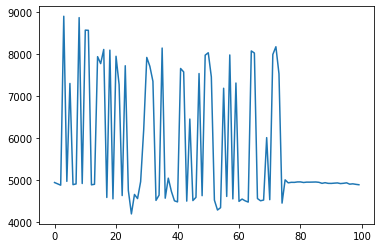

In [39]:
x1 = np.arange(0,np.size(ERR))
plt.plot(x1,ERR)

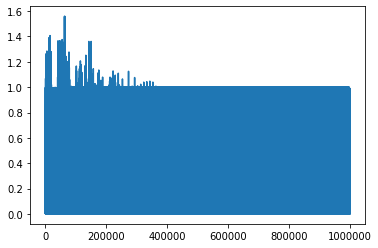

In [16]:
x1 = np.arange(0,np.size(ERR_entire))
plt.plot(x1,ERR_entire)